In [1]:
import ehc_sn as ehc
import matplotlib.pyplot as plt
import torch

import plots

In [2]:
import tomllib as toml

with open("configurations/balanced_network.toml", "rb") as f:
    data = toml.load(f)

In [3]:
parameters = ehc.Parameters.model_validate(data)
model = ehc.Network(p=parameters)
model = torch.compile(model)
model.eval()

OptimizedModule(
  (_orig_mod): Network(
    (excitatory): EILayer(
      (neurons): BaseLayer(p=LIFRefracParameters(lif=LIFParameters(tau_syn_inv=tensor(0.2000, device='cuda:0'), tau_mem_inv=tensor(0.5000, device='cuda:0'), v_leak=tensor(-60., device='cuda:0'), v_th=tensor(-50., device='cuda:0'), v_reset=tensor(-60., device='cuda:0'), method='super', alpha=tensor(0.5000, device='cuda:0')), rho_reset=tensor(5, device='cuda:0')), dt=0.001)
      (ampa): Inputs()
      (gaba): Inputs()
    )
    (inhibitory): EILayer(
      (neurons): BaseLayer(p=LIFRefracParameters(lif=LIFParameters(tau_syn_inv=tensor(0.1000, device='cuda:0'), tau_mem_inv=tensor(0.5000, device='cuda:0'), v_leak=tensor(-50., device='cuda:0'), v_th=tensor(-50., device='cuda:0'), v_reset=tensor(-60., device='cuda:0'), method='super', alpha=tensor(0.5000, device='cuda:0')), rho_reset=tensor(5, device='cuda:0')), dt=0.001)
      (ampa): Inputs()
      (gaba): Inputs()
    )
  )
)

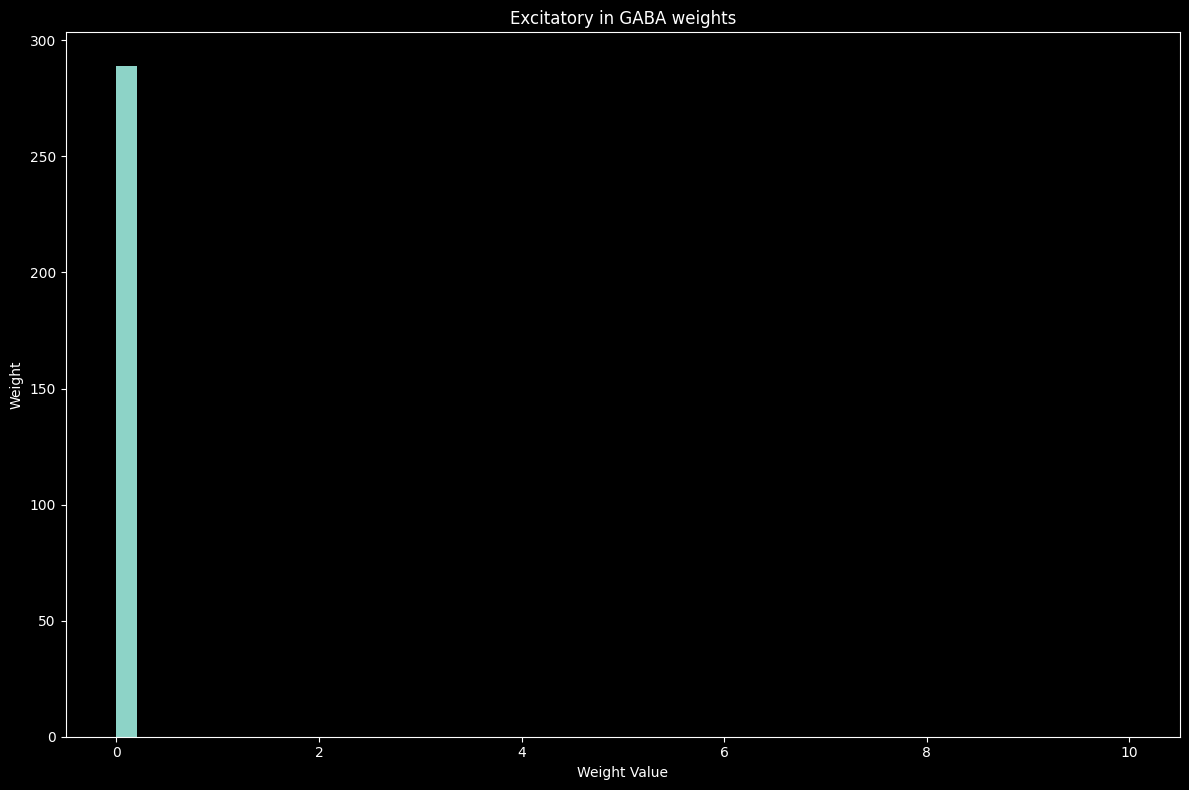

In [4]:
w = model.excitatory.gaba.w.detach().cpu()
mask = model.excitatory.gaba.mask.detach().cpu()
filtered_weights = w.masked_select(mask)
plots.weights(filtered_weights, "Excitatory in GABA weights")

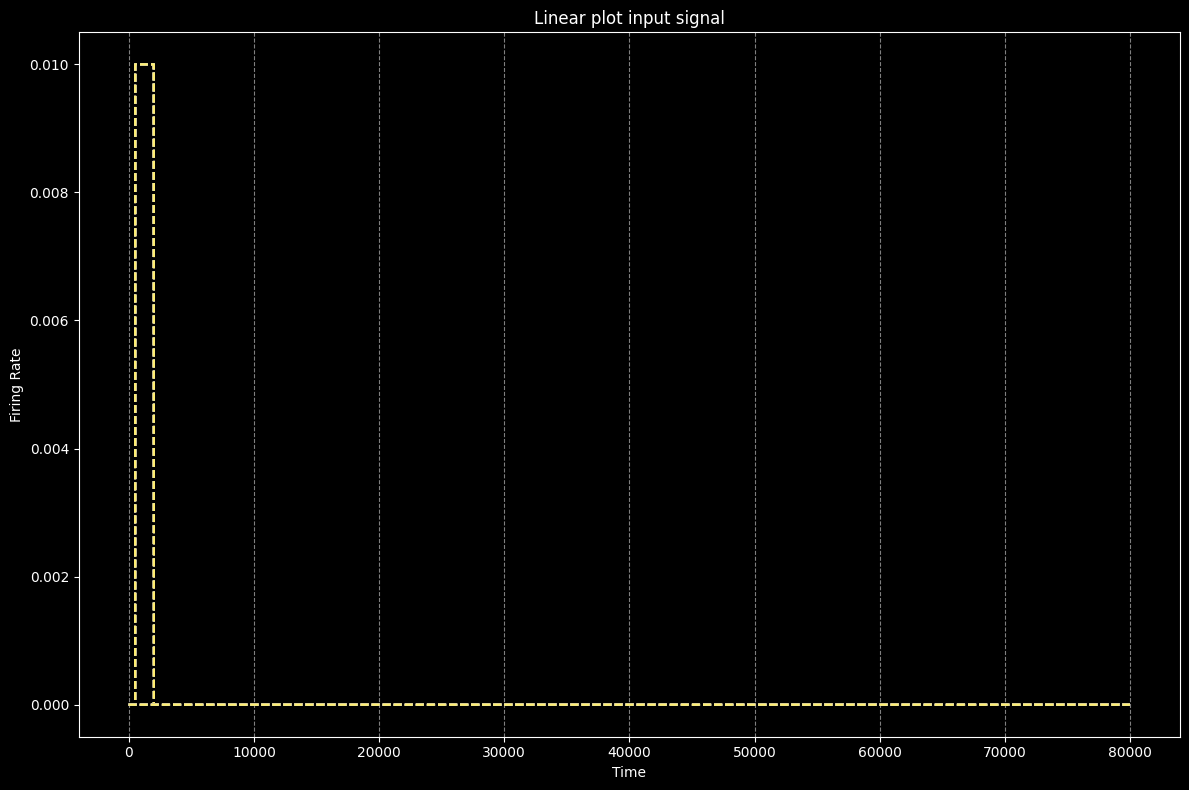

In [5]:
signal_in = torch.zeros(80000, 40).to(ehc.device)
signal_in[500:2000, :20] = 0.01
plots.signal(signal_in.cpu(), "Linear plot input signal")

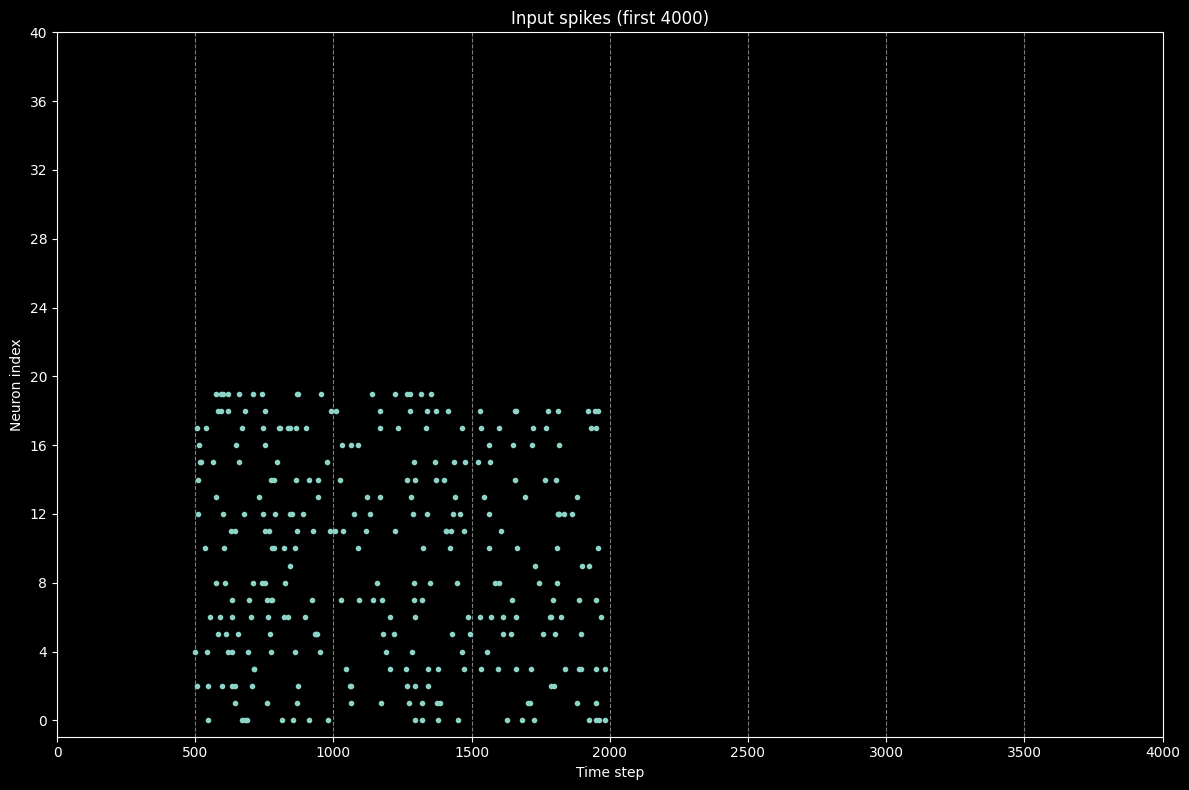

In [6]:
encoder = ehc.encoders.PoissonEncoder()
spikes_in = torch.stack([encoder(x) for x in signal_in])
plots.raster(spikes_in[:4000].cpu(), "Input spikes (first 4000)")

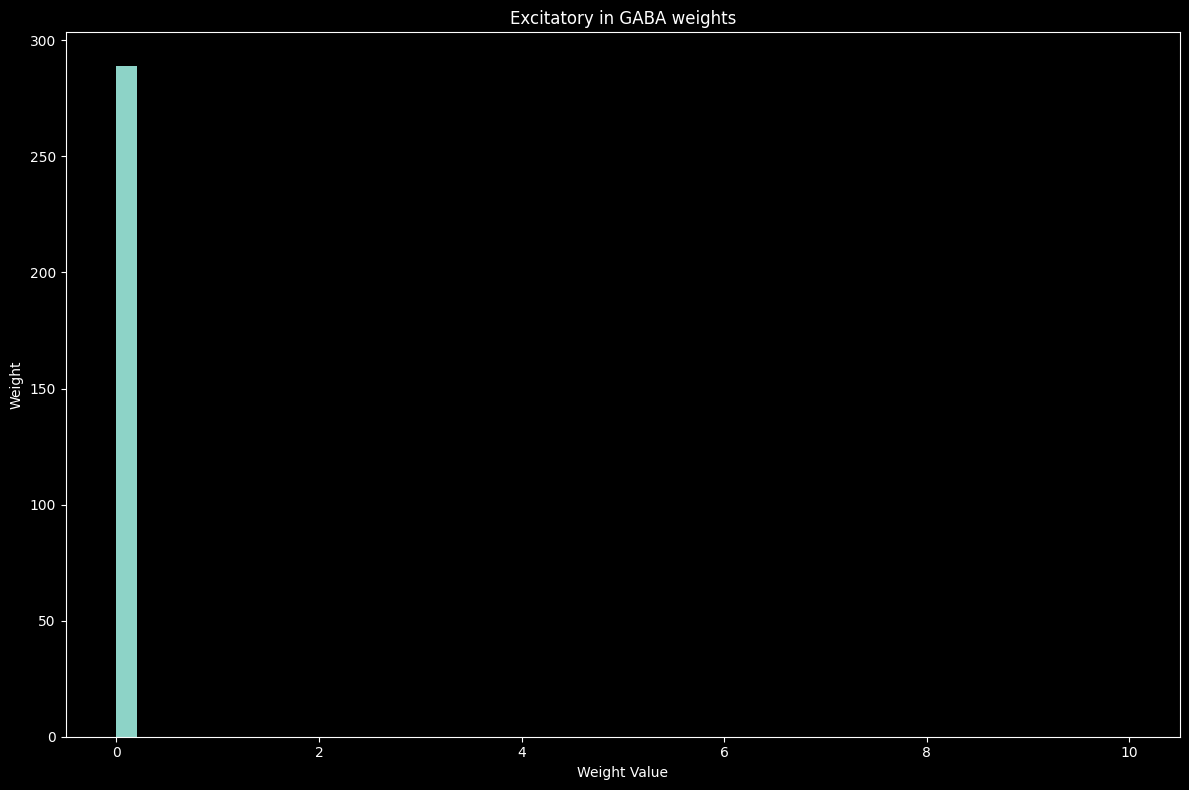

In [7]:
w = model.excitatory.gaba.w.detach().cpu()
mask = model.excitatory.gaba.mask.detach().cpu()
filtered_weights = w.masked_select(mask)
plots.weights(filtered_weights, "Excitatory in GABA weights")

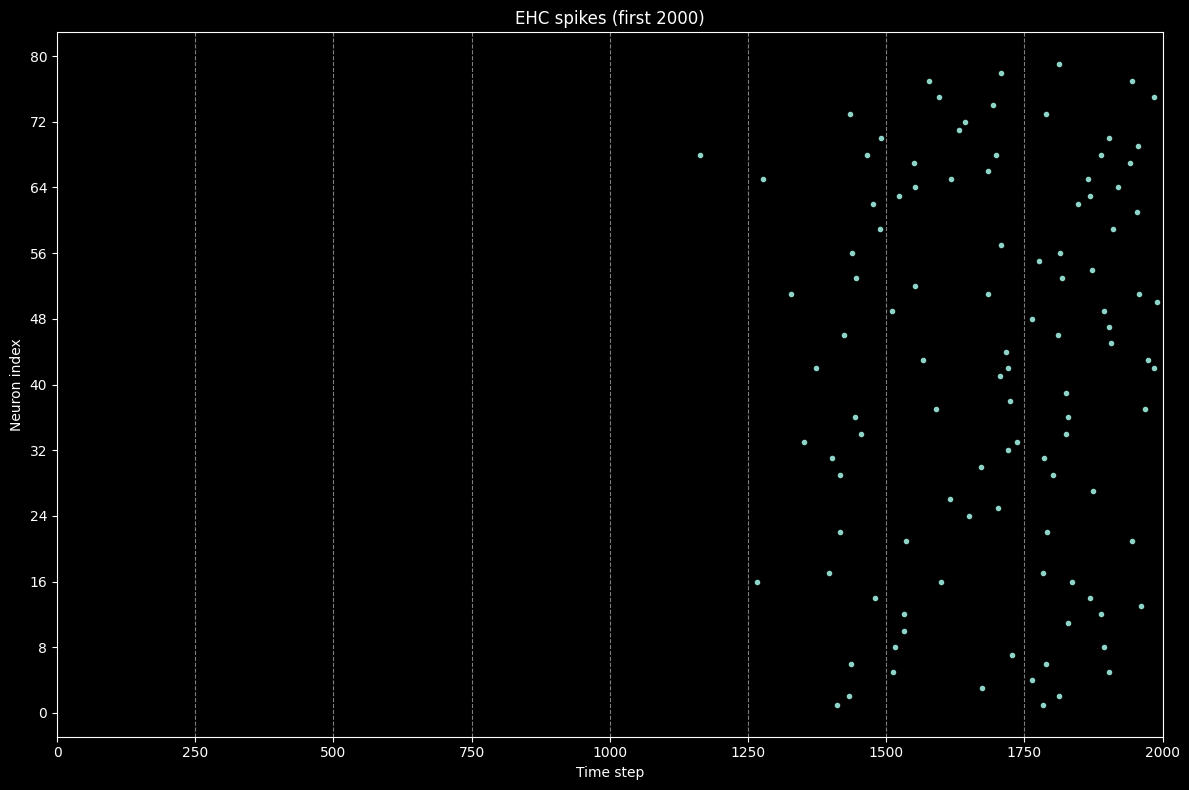

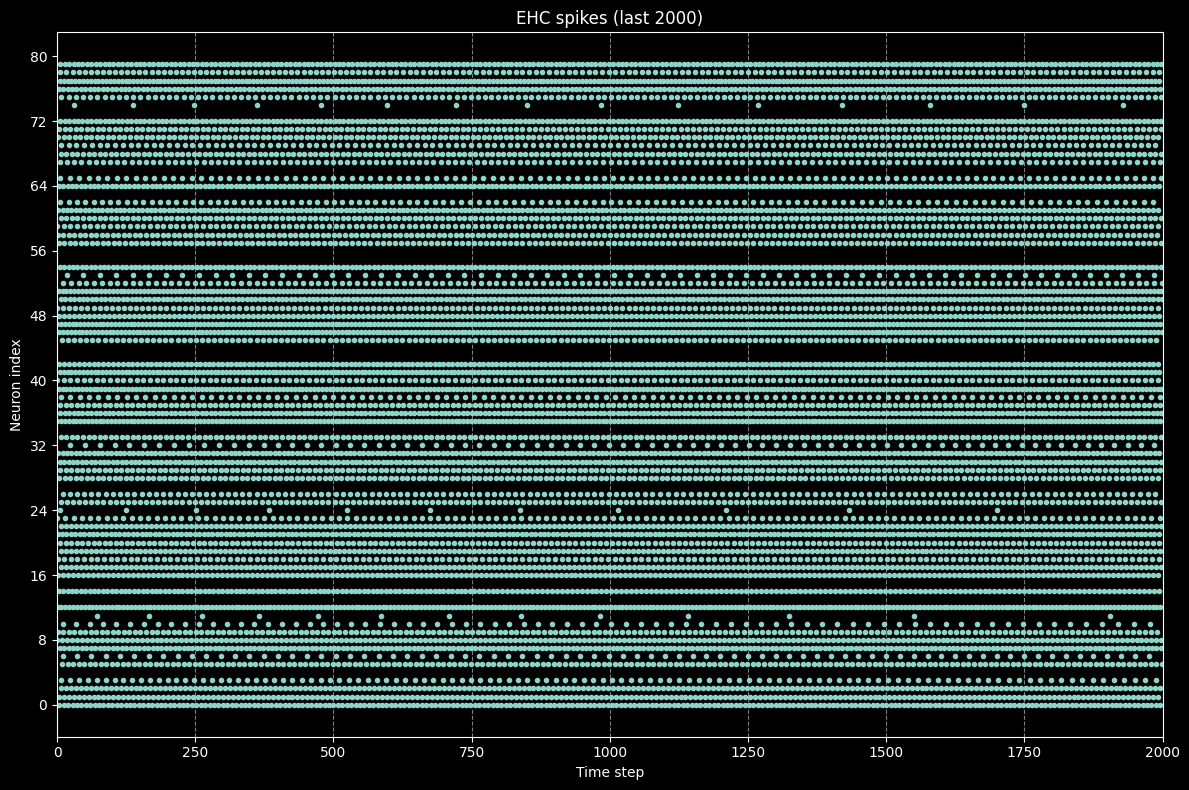

In [8]:
spikes_out = torch.stack([model(x) for x in spikes_in])
plots.raster(spikes_out[:2000].cpu(), "EHC spikes (first 2000)")
plots.raster(spikes_out[-2000:].cpu(), "EHC spikes (last 2000)")

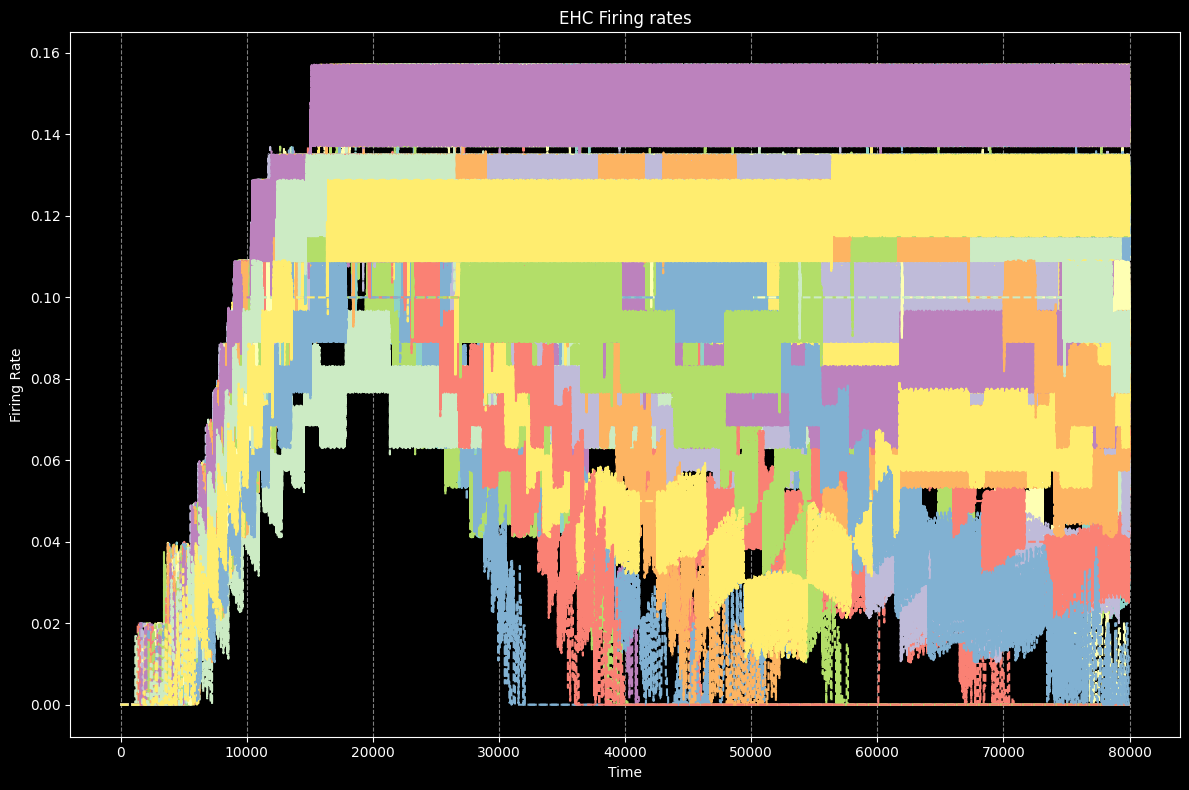

In [9]:
decoder = ehc.decoders.HannDecoder(window_length=100)
signal_out = torch.stack([decoder(x) for x in spikes_out])
signal_out = signal_out.detach()
plots.signal(signal_out.cpu(), "EHC Firing rates")

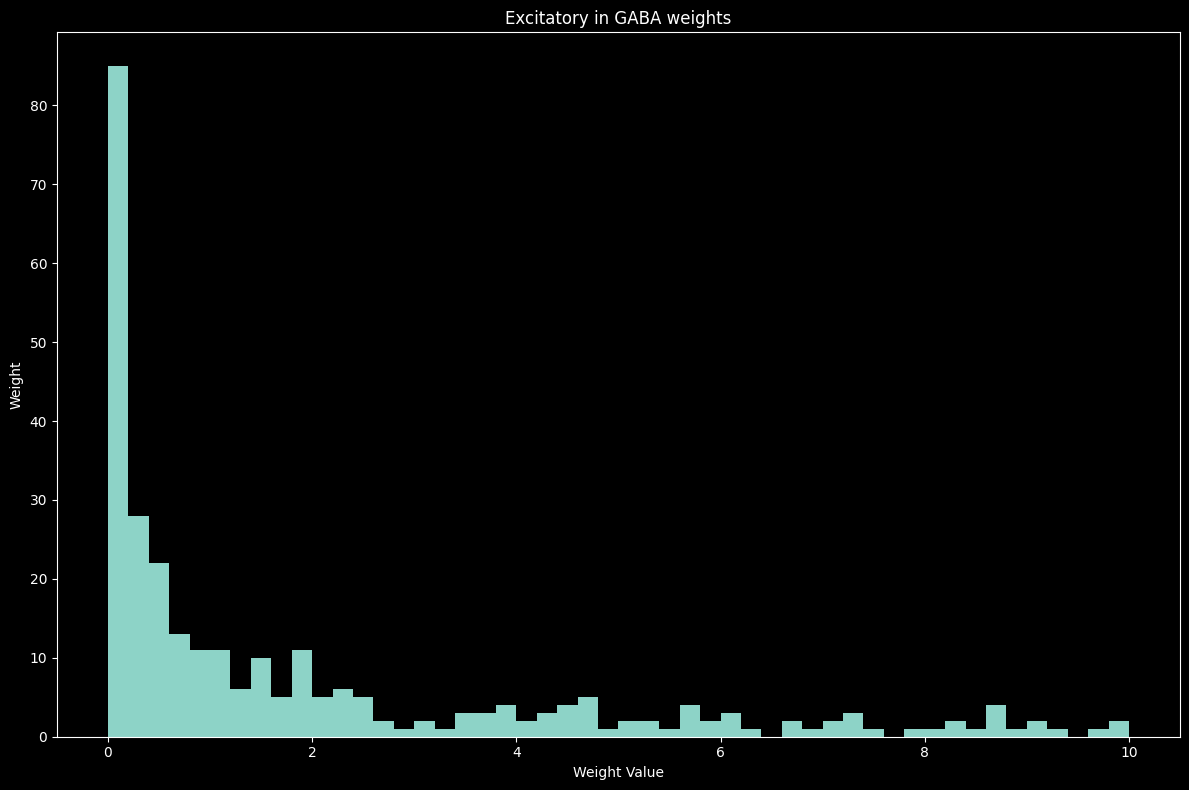

In [10]:
w = model.excitatory.gaba.w.detach().cpu()
mask = model.excitatory.gaba.mask.detach().cpu()
filtered_weights = w.masked_select(mask)
plots.weights(filtered_weights, "Excitatory in GABA weights")